#Profile Submission

> Nama : Hamidan Z Wijasena

> Email : hamidanzaneddinewijasena@gmail.com


#Submission: Image Classification Model Deployment
Requirements 

1. Dataset yang akan dipakai bebas, namun minimal memiliki 1000 buah gambar.
2. Dataset dibagi menjadi 80% train set dan 20% test set.
3. Model harus menggunakan model sequential.
4. Model harus menggunakan Conv2D Maxpooling Layer.
5. Akurasi pada training dan validation set minimal sebesar 80%.
6. Menggunakan Callback.
7. Membuat plot terhadap akurasi dan loss model.
8. Menulis kode untuk menyimpan model ke dalam format TF-Lite.

> Dataset : https://www.kaggle.com/madisona/translated-animals10


In [ ]:
#Import dataset dari gdrive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Import Library yang akan digunakan

import os
import shutil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [ ]:
# listing dataset gambar hewan

animals10 = os.path.join('/content/drive/MyDrive/Colab Notebooks/Latihan/Deploy TF-Live/animals10/raw-img/')
print(os.listdir(animals10))

['dog', 'chicken', 'spider', 'elephant']


# Pre-Processing

In [ ]:
# Listing dataset gambar

list_animals10 = os.listdir(animals10)
print(list_animals10)

['dog', 'chicken', 'spider', 'elephant']


In [ ]:
# Print total dataset hewan

total = 0

for x in list_animals10:
  dir = os.path.join(animals10, x)
  y = len(os.listdir(dir))
  print(x + ':', y)
  total = total + y
  
  img_name = os.listdir(dir)
  for z in range(4):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('-',img.size)
  print('---------------')

print('\nTotal :', total)

dog: 4863
- (300, 300)
- (300, 200)
- (225, 300)
- (300, 199)
---------------
chicken: 3118
- (300, 225)
- (300, 275)
- (300, 200)
- (300, 225)
---------------
spider: 4831
- (300, 300)
- (300, 300)
- (300, 200)
- (300, 200)
---------------
elephant: 1446
- (300, 225)
- (300, 202)
- (300, 200)
- (300, 225)
---------------

Total : 14258


<function matplotlib.pyplot.show>

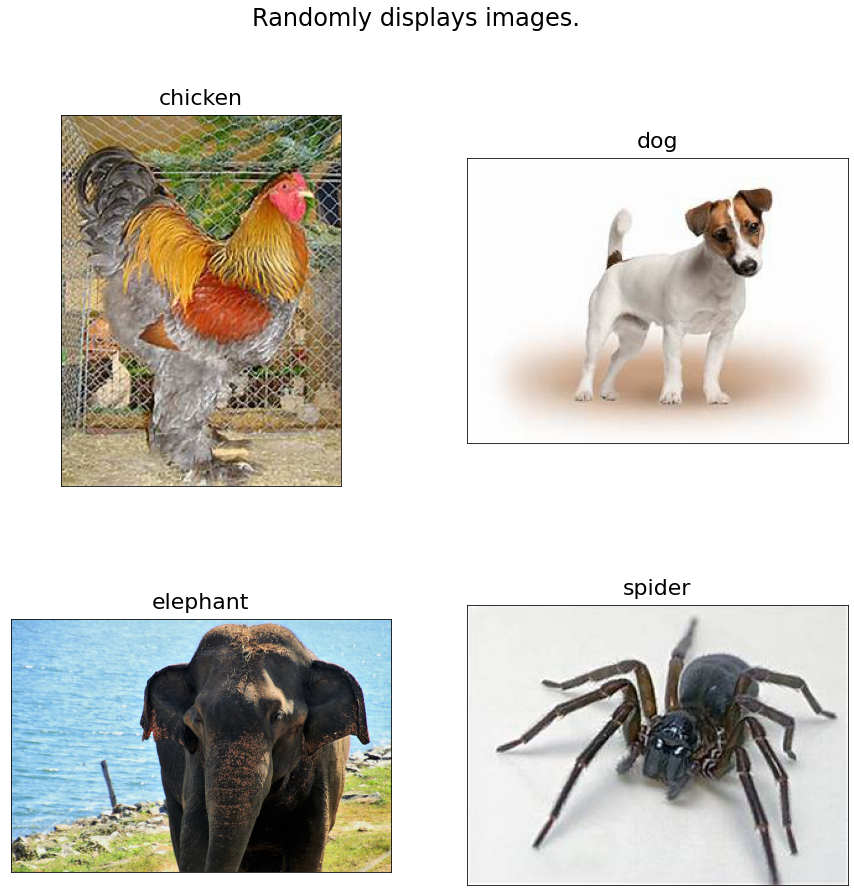

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (15,15))
fig.suptitle("Randomly displays images.", fontsize = 24)
animals_sorted = sorted(list_animals10)
animals_id = 0
for i in range(2):
  for j in range(2):
    try:
      animals_selected = animals_sorted[animals_id] 
      animals_id += 1
    except:
      break
    if animals_selected == '.TEMP':
        continue
    animals_selected_images = os.listdir(os.path.join(animals10, animals_selected))
    animals_selected_random = np.random.choice(animals_selected_images)
    images = plt.imread(os.path.join(animals10, animals_selected, animals_selected_random))
    ax[i][j].imshow(images)
    ax[i][j].set_title(animals_selected, pad=10, fontsize=22)
    
plt.setp(ax, xticks=[],yticks=[])
plt.show

# Model Building

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1/255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2   
)

In [ ]:
batch_size = 256

data_train = train_datagen.flow_from_directory(
    animals10,
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

data_val = train_datagen.flow_from_directory(
    animals10, 
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation')

Found 11408 images belonging to 4 classes.
Found 2850 images belonging to 4 classes.


In [ ]:
# Detail Deep Learning Neural Networks Layer 

tf.device('/device:GPU:0')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3 ), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [ ]:
# Callback

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.93 and logs.get('val_accuracy') > 0.93):
      print("\nAccuracy above 93%, finish training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
# Fitting Model

history = model.fit(data_train, 
                    epochs = 100, 
                    steps_per_epoch = data_train.samples // batch_size,
                    validation_data = data_val, 
                    validation_steps = data_val.samples // batch_size,
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/100
44/44 [==============================] - 5345s 122s/step - loss: 1.2963 - accuracy: 0.3822 - val_loss: 1.2482 - val_accuracy: 0.4574
Epoch 2/100
44/44 [==============================] - 99s 2s/step - loss: 1.1399 - accuracy: 0.5080 - val_loss: 1.1122 - val_accuracy: 0.5312
Epoch 3/100
44/44 [==============================] - 98s 2s/step - loss: 1.0365 - accuracy: 0.5716 - val_loss: 1.0288 - val_accuracy: 0.5664
Epoch 4/100
44/44 [==============================] - 99s 2s/step - loss: 0.9494 - accuracy: 0.6108 - val_loss: 0.9434 - val_accuracy: 0.6264
Epoch 5/100
44/44 [==============================] - 97s 2s/step - loss: 0.8766 - accuracy: 0.6509 - val_loss: 0.7992 - val_accuracy: 0.6903
Epoch 6/100
44/44 [==============================] - 99s 2s/step - loss: 0.7556 - accuracy: 0.7121 - val_loss: 0.6651 - val_accuracy: 0.7333
Epoch 7/100
44/44 [==============================] - 99s 2s/step - loss: 0.7045 - accuracy: 0.7279 - val_loss: 0.6671 - val_accuracy: 0.7464
Epoch 8/1

# Model Evaluation

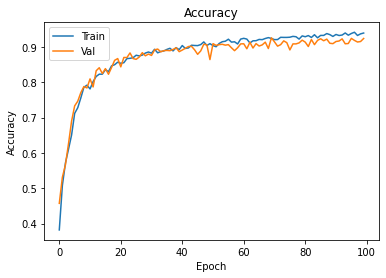

In [ ]:
# Plot Hasil Akurasi Training dan Validation

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

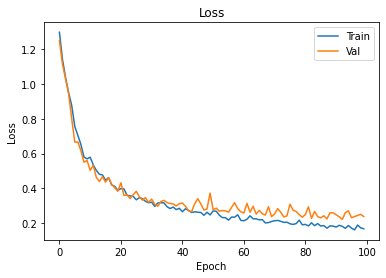

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# Menulis kode untuk menyimpan model ke dalam format TF-Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpaukd465v/assets
